# FIT5196 Assessment 2 Task 1
#### Student Name: Dariush Riazati
#### Student ID: 11230991

Date: 09/06/2019

Version: 1.0

Environment: Python 3.5.2 and Jupyter notebook

In [1]:
from sys import version
print(version)

3.5.2 (v3.5.2:4def2a2901a5, Jun 25 2016, 22:18:55) [MSC v.1900 64 bit (AMD64)]


In [2]:
from __future__ import division
import pandas as pd
import re
import numpy as np
import time
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.probability import *
import matplotlib.pyplot as plt
from itertools import chain
import nltk
from difflib import SequenceMatcher
from collections import Counter
import csv
import statistics
import scipy.stats as stats
import datetime

### Initialization

In [3]:
# add a bit of styling!
plt.style.use('bmh')

# make sure the plots are shown in the notebook
%matplotlib inline 

# adjust the figure size to have larger plots
plt.rcParams['figure.figsize'] = 10, 5

# Creating matching between company values takes time. Once we calculated it, we save it anduse that for subsequent runs
# to speed up the process. This boolean variable indicates if we want to re-uuse pre-calculated matchings or not.

company_match_file = True

### Functions

In [4]:
# the following function is the clean and normalize title column.
def cleanTitle(token):
    if pd.isnull(token):
        return token
    else:
        # normalize to upper case letters
        token = token.upper()        
        
        # replace 1ST with FIRST
        token = token.replace("1ST", "FIRST")
        # replace 1ST with FIRST
        token = token.replace("2ND", "SECOND")
        token = token.replace("3RD", "THIRD")
        token = token.replace("4TH", "FOURTH")
        token = token.replace(" MTH ", " MONTH ")
        token = re.sub(r"^Y1 ", "YEAR 1 ", token)
        token = re.sub(r"^Y2 ", "YEAR 2 ", token)
        token = re.sub(r"^Y3 ", "YEAR 3 ", token)
        token = re.sub(r"^Y4 ", "YEAR 4 ", token)
        token = re.sub(r"^Y5 ", "YEAR 5 ", token)
        token = re.sub(r"â€“", "", token)
        
        # remove all special characters except space. +, / and dot
        token = re.sub(r'([^\w\s\.\/\+]|_)', '', token)
        token = re.sub('^\s+', '', token)
        # replace multiple spaces with a single space, also trim spaces on both side
        token = re.sub( '\s+', ' ', token).strip()
        return token

In [5]:
# the following function is the clean and normalize title column.
def cleanLocationCompany(token):
    if pd.isnull(token):
        return token
    else:
        # normalize to upper case letters
        token = token.upper()        
        token = re.sub(r"â€“", "", token)
        
        # remove all special characters except space. +, / and dot
        token = re.sub(r'([^\w\s\.\/\+]|_)', '', token)
        token = re.sub('^\s+', '', token)
        # replace multiple spaces with a single space, also trim spaces on both side
        token = re.sub( '\s+', ' ', token).strip()
        return token

In [6]:
# This function splits a given ngram based on a list of given stems. 
def splitLong(long, stem):
    nw = ''
    for each_stem in stem:
        my_regex = r"(" + re.escape(each_stem) + r")"
        splits = re.split(my_regex, long)
        nw = ''
        for w in splits:
            nw = nw + ' ' + w
    
        long = nw
    
    nw = re.sub( '\s+', ' ', nw).strip()
    return nw.strip()

In [7]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [8]:
def match_highfreq_To_lowfreq(data, min_threshold, max_threshold):
    # check low frequency company names
    lowfreq_data_list = [k for k,v in Counter(data).items() if v<=5]
    print ("Number of lowfreq_data", len(lowfreq_data_list))
    highfreq_data_list = list(set(data[~(data.isnull())]).difference(lowfreq_data_list))
    print ("Number of highfreq_data", len(highfreq_data_list))
    # the printed data tells that probably not many companies posted more than 5 jobs in those years.


    match_data={}
    for lowfreq_data in lowfreq_data_list:
        for highfreq_data in highfreq_data_list:
            ratio = similar(lowfreq_data.upper(), highfreq_data.upper())
            if ratio >= min_threshold and ratio <= max_threshold:
                match_data[lowfreq_data] = highfreq_data
                print(lowfreq_data, ":", highfreq_data, ratio)
    return match_data

In [9]:
def clean_salary(s):
    #x1 = s.replace('YEAR','').replace('/','').replace('PER ANNUM','').replace('.00', '').replace('.0', '')
    x1 = s.replace('YEAR','').replace('/','').replace('PER ANNUM','')
    x2 = x1.replace(' TO ', ' - ').replace('PA', '').replace('K', '000').replace('.47', '')
    x3  = x2.replace('.42', '').replace('.7', '').replace('.17', '')
    x   = x3.replace('P/H', '@').replace('PER HOUR', '@').replace('PH', '@')
    
    if x.find(' - ') != -1:
        xar = x.split(' - ')
        f = float(xar[0].strip())
        t = float(xar[1].strip())
        x = round(statistics.mean([f,t]))
    elif x.strip().find('-') != -1:
        x = 'NAN'
    elif x.find('@') != -1:
        xar = str(x).split('@')
        x = float(xar[0].strip()) * 1950
        print(xar[0].strip(), "changed to ", x)
        
    return str(x)

In [10]:
def getLowerUpper(df, cat):
    df_cat = df[df.category == cat]
    q1 = np.percentile(df_cat.salary, 25)
    q3 = np.percentile(df_cat.salary, 75)
    lq = q1 - (1.5*(q3 - q1)) 
    uq = q3 + (1.5*(q3 - q1))
    return(cat, lq, uq)

def getLowerOutliers(df, cat, l):
    ols = df[(df.salary < l) & (df.category == cat)]
    return ols

def getUpperOutliers(df, cat, u):
    ols = df[(df.salary > u) & (df.category == cat)]
    return ols

In [11]:
# This function replaces null salaries in each category with the pre-calculated average.
def repna(row):
    if   row.category == 'Accounting & Finance Jobs' and row.salary_corrected == 'NAN':
        sal='40042'
    elif row.category == 'Engineering Jobs' and row.salary_corrected == 'NAN':
        sal='33541'
    elif row.category == 'Healthcare & Nursing Jobs' and row.salary_corrected == 'NAN':
        sal='30139'
    elif row.category == 'Hospitality & Catering Jobs' and row.salary_corrected == 'NAN':
        sal='22343'
    elif row.category == 'IT Jobs' and row.salary_corrected == 'NAN':
        sal='43587'
    elif row.category == 'PR, Advertising & Marketing Jobs' and row.salary_corrected == 'NAN':
        sal='32276'
    elif row.category == 'Sales Jobs' and row.salary_corrected == 'NAN':
        sal='28285'
    elif row.category == 'Teaching Jobs' and row.salary_corrected == 'NAN':
        sal='26391'
    else:
        sal = row.salary_corrected
    
    #row.salary_corrected = sal
    return sal

In [12]:
def repMe(x, y, z):
     if x == y: 
        return z 
     else: 
        return x

In [13]:
def rep_numonly(x):
    if re.match("^[\d]+$", str(x)):
       return 'non-specified'
    else:
       return x

In [14]:
def compareDates(row):
    f = row.fromTime
    t = row.toTime
    i = int(row.id)
    if f > t:
        return 'Y'

In [15]:
def swapDates(row):
    id = row.id
    od = row.open_date
    cd = row.close_date
    if row.invalid_date == 'Y':
        row.open_date = cd
        row.close_date = od
    return row

###### Read CSV

In [16]:
dft = pd.read_csv('dataset1_with_error.csv', sep=",", names=['id', 'title', 'location', 'company',
                        'contract_type', 'contract_time', 'category', 'salary', 'open_date', 'close_date', 'source'],
                            encoding = "utf-8", skiprows=1)

### Audit id

In [17]:
print ("number of missing ids:", dft.id.isnull().sum())
print("Is there any duplicate in the id column?", dft.id.value_counts().reset_index(name="count").query("count > 1")["index"])
# Get group counts for id and flag it if numeric
s = pd.Series(dft['id'].values, index=dft['id'])
s['num'] = s.astype(str).str.isnumeric()
ss = s['num'].value_counts()
pd.DataFrame({'id':ss.index, 'numeric':ss.values})
print("Change Summary: id column has no null value, all numeric and no suplicate.")

number of missing ids: 0
Is there any duplicate in the id column? Series([], Name: index, dtype: int64)


,id,numeric
0,True,55169


Change Summary: id column has no null value, all numeric and no suplicate.


### Audit Title

In [18]:
dft[dft.title.apply(lambda x: len(x) < 3)]

,id,title,location,company,contract_type,contract_time,category,salary,open_date,close_date,source
23603,69004885,HR,UK,Supreme Recruitment,NaN,permanent,Teaching Jobs,35000,20120330T150000,20120429T150000,cv-library.co.uk
31962,69759443,QA,Manchester,-,full_time,-,Engineering Jobs,32640,20131218T000000,20140318T000000,Jobcentre Plus


In [19]:
print("We can see that there is a mix of cases.")
dft.title.head(10)
dft.title.tail(10)

We can see that there is a mix of cases.


0                          Engineering Systems Analyst
1                              Stress Engineer Glasgow
2                     Modelling and simulation analyst
3    Engineering Systems Analyst / Mathematical Mod...
4           Pioneer, Miser Engineering Systems Analyst
5              Trainee Mortgage Advisor  East Midlands
6                     PROJECT ENGINEER, PHARMACEUTICAL
7    Chef de Partie  Award Winning Restaurant  Exce...
8                                     Quality Engineer
9    Chef de Partie  Award Winning Dining  Live In ...
Name: title, dtype: object

55159    IT Infrastructure Specialist (Mlnlycke Health ...
55160    Pharmaceutical  Analytical Chemist Jobs in Nor...
55161       Medical Sales Representative  South East Essex
55162    SENIOR PROJECT MANAGER  EVENT & EXHIBITION AGENCY
55163                       Curriculum Leader  Mathematics
55164                  TEACHER OF BUSINESS STUDIES AND LAW
55165         Pensions Administrators (Temporary/Contract)
55166                             Senior Financial Advisor
55167      Barclays Future Leaders Development Programmes 
55168    Quality Assurance Environmental Manager Nottin...
Name: title, dtype: object

In [20]:
print (len(set(dft.title)), "different titles before normalization")
dft['TitleNormalized'] = dft.title.apply(lambda x: cleanTitle(x))
print (len(set(dft.TitleNormalized)), "different titles after normalization")

55166 different titles before normalization
55162 different titles after normalization


In [21]:
# We treat most of the ngram words by splitting them for clarity. That does not change the frequency.
print (len(set(dft.TitleNormalized)), "different titles before split")
s = ['MANAGER', 'DIRECTOR', 'ANALYST', 'DEVELOPER', 'ENGINEER', 'BOOKKEEPER', 
    'DEVELOPMENT']
dft['TitleSplit'] = dft.TitleNormalized.apply(lambda x: splitLong(x, s))
print (len(set(dft.TitleSplit)), "different titles after split")

55162 different titles before split
55162 different titles after split


In [22]:
# The job titles appear to be unique, therefore repalcing them with similar ones of higher frequency does not help.
len(dft.TitleNormalized.unique())
match_data=match_highfreq_To_lowfreq(dft.TitleSplit, 0.95, 1)

55162

Number of lowfreq_data 55162
Number of highfreq_data 0


In [23]:
dft[dft.TitleNormalized == '']
dft['TitleNormalized'] = dft.TitleNormalized.apply(lambda x: repMe(x, '', 'non-specified'))
dft[dft.TitleNormalized == '']

,id,title,location,company,contract_type,contract_time,category,salary,open_date,close_date,source,TitleNormalized,TitleSplit
1043,50870368,****,UK,Rullion Engineering Ltd,NaN,permanent,Engineering Jobs,34500,20120427T120000,20120726T120000,cv-library.co.uk,,


,id,title,location,company,contract_type,contract_time,category,salary,open_date,close_date,source,TitleNormalized,TitleSplit


In [24]:
# we don't need TitleNormalized and the old title any more.
dft = dft.drop(['TitleSplit'], axis=1)
dft = dft.drop(['title'], axis=1)

##### Validation Summeary:
- Check for short length
- Clean from special characters, spaces
- Make spellings consistent
- Split compond nouns
- Check for frequencies to see if similarity can be used to correct less frequent words
- Replace null values

### Audit Location

In [25]:
print ("number of missing locations:", dft.location.isnull().sum())

number of missing locations: 0


In [26]:
print (len(set(dft.location)), "different locations before normalization")
dft['LocationNormalized'] = dft.location.apply(lambda x: cleanLocationCompany(x))
print (len(set(dft.LocationNormalized)), "different titles after normalization")

489 different locations before normalization
484 different titles after normalization


In [27]:
dft.location.value_counts()

UK                      8397
London                  7046
South East London       2961
The City                1184
Central London           889
Manchester               754
Leeds                    733
Surrey                   686
Birmingham               639
Reading                  604
West Midlands            579
Bristol                  471
Berkshire                441
East Sheen               437
Nottingham               409
Oxford                   395
Hampshire                387
Milton Keynes            383
Sheffield                383
Kent                     362
Cambridge                358
Newcastle Upon Tyne      346
Guildford                340
Leicester                311
Hertfordshire            301
Liverpool                286
Aberdeen                 282
Essex                    282
Oxfordshire              275
West Yorkshire           273
                        ... 
Grimsby                   11
Wincanton                 11
Sutton-In-Ashfield        11
Trent         

In [28]:
match_location=match_highfreq_To_lowfreq(dft.LocationNormalized, 0.85, 1)

Number of lowfreq_data 5
Number of highfreq_data 479
OXFORDS : OXFORD 0.9230769230769231
MANCHASTER : MANCHESTER 0.9
LIVEPOOL : LIVERPOOL 0.9411764705882353
CEMBRIDGE : CAMBRIDGE 0.8888888888888888


In [29]:
# replace lower frequent with higher frequent location name
dft['location_similar'] = dft.LocationNormalized.replace(match_location)

In [30]:
dft['location_similar'].value_counts()

UK                     8397
LONDON                 7048
SOUTH EAST LONDON      2961
THE CITY               1184
CENTRAL LONDON          889
MANCHESTER              755
LEEDS                   733
SURREY                  686
BIRMINGHAM              641
READING                 604
WEST MIDLANDS           579
BRISTOL                 472
BERKSHIRE               441
EAST SHEEN              437
NOTTINGHAM              409
OXFORD                  397
HAMPSHIRE               389
SHEFFIELD               383
MILTON KEYNES           383
KENT                    362
CAMBRIDGE               359
NEWCASTLE UPON TYNE     346
GUILDFORD               340
LEICESTER               311
HERTFORDSHIRE           301
LIVERPOOL               287
ABERDEEN                284
ESSEX                   282
OXFORDSHIRE             275
WEST YORKSHIRE          273
                       ... 
PETERSFIELD              11
BROADFIELD               11
SUTTONINASHFIELD         11
TWICKENHAM               11
WINCANTON           

In [31]:
# replace lower frequent with higher frequent location name
dft['location_similar'].replace({'NEWCASTLEUNDERLYME':'NEWCASTLE UNDER LYME',
                                  'LEADS':'LEEDS'},inplace=True)

In [32]:
dft['location_similar'].value_counts()

UK                      8397
LONDON                  7048
SOUTH EAST LONDON       2961
THE CITY                1184
CENTRAL LONDON           889
MANCHESTER               755
LEEDS                    734
SURREY                   686
BIRMINGHAM               641
READING                  604
WEST MIDLANDS            579
BRISTOL                  472
BERKSHIRE                441
EAST SHEEN               437
NOTTINGHAM               409
OXFORD                   397
HAMPSHIRE                389
MILTON KEYNES            383
SHEFFIELD                383
KENT                     362
CAMBRIDGE                359
NEWCASTLE UPON TYNE      346
GUILDFORD                340
LEICESTER                311
HERTFORDSHIRE            301
LIVERPOOL                287
ABERDEEN                 284
ESSEX                    282
OXFORDSHIRE              275
WEST YORKSHIRE           273
                        ... 
JERSEY                    12
LEWISHAM                  11
BOURNE END                11
ALCESTER      

In [33]:
# we don't need TitleNormalized and the old title any more.
dft = dft.drop(['LocationNormalized'], axis=1)
dft = dft.drop(['location'], axis=1)

##### Validation summary:
- Check for nulls
- Correct formatting by replacing special characters and multiple spaces
- CHeck frequencies to see if high frequent words can replace similar less frequent words

### Audit Company

In [34]:
len(dft[dft.company == ''])
len(dft)

0

55169

In [35]:
no_null_companies = dft.company.isnull().sum()
perc = round(no_null_companies/len(dft), 2)
print ("number of missing companies:", no_null_companies)
print ("Percentage of missing companies:", int(perc*100), '%')

number of missing companies: 3849
Percentage of missing companies: 7 %


In [36]:
dft['CompanyNormalized'] = dft.company.apply(lambda x: cleanLocationCompany(x))

In [37]:
if company_match_file:
    match_company = csv.DictReader(open('match_company.csv'))
else:
    match_company=match_highfreq_To_lowfreq(dft.CompanyNormalized, 0.95, 1)
    dft.to_csv('match_company.csv')
    company_match_file = True

In [38]:
dft['company_similar'] = dft.CompanyNormalized.replace(match_company)

In [39]:
dft['company_similar'].value_counts()

                                                          1539
UKSTAFFSEARCH                                              498
RANDSTAD                                                   403
CVBROWSER                                                  328
PENGUIN RECRUITMENT                                        252
MATCHTECH GROUP PLC.                                       242
HAYS                                                       230
LONDON4JOBS                                                201
CORECRUITMENT INTERNATIONAL                                197
JOBG8                                                      184
CHEF RESULTS                                               177
JAM RECRUITMENT LTD                                        171
POPULUS HEALTHCARE                                         146
MICHAEL PAGE FINANCE                                       136
COMPUTER PEOPLE                                            135
SENITOR ASSOCIATES                                     

In [40]:
 dft[dft.company_similar == 'nonnon-specifiedspecified']

,id,company,contract_type,contract_time,category,salary,open_date,close_date,source,TitleNormalized,location_similar,CompanyNormalized,company_similar


In [41]:
dft['company_similar'] = dft.company_similar.str.replace('LTD', 'LIMITED')
dft['company_similar'] = dft.company_similar.fillna('non_specified')

In [42]:
dft['company_similar'] = dft.company_similar.str.replace('-', 'non-specified')
dft['company_similar'] = dft.company_similar.str.replace('_', '-')

In [43]:
dft.company_similar.isnull().sum()
len(dft[dft.company_similar == ''])
dft['company_similar'] = dft.company_similar.apply(lambda x: repMe(x, '', 'non-specified'))
dft['company_similar'] = dft.company_similar.apply(lambda x: repMe(x, '.', 'non-specified'))
len(dft[dft.company_similar == ''])
len(dft[dft.company_similar == 'N/A'])

0

1539

0

0

In [44]:
dft['company_similar'] = dft.company_similar.apply(lambda x: rep_numonly(x))

In [45]:
no_null_companies = dft.company_similar.isnull().sum()
perc = round(no_null_companies/len(dft), 2)
print ("number of missing companies:", no_null_companies)
print ("Percentage of missing companies:", int(perc*100), '%')

number of missing companies: 0
Percentage of missing companies: 0 %


In [46]:
len(dft[dft.company_similar == '-'])
len(dft[dft.company_similar.isnull()])
len(dft[dft.company_similar == '.'])

0

0

0

In [47]:
# we don't need old company columns and the old title any more.
dft = dft.drop(['CompanyNormalized'], axis=1)
dft = dft.drop(['company'], axis=1)

###### Validation Summary:
- Check for nulls
- Replace highly frquent companies with similar low frequent companies
- Replace nulls, dashes and 

### Audit Contact Type

In [48]:
dft.contract_type.value_counts()
len(dft[dft.contract_type.isna()])

             14902
full_time    12303
-             4720
part_time     1568
Name: contract_type, dtype: int64

21676

In [49]:
# It appears that N/A values are also being considered as NaN
dft[dft.id == 12612628]

,id,contract_type,contract_time,category,salary,open_date,close_date,source,TitleNormalized,location_similar,company_similar
0,12612628,NaN,permanent,Engineering Jobs,25000,20130708T120000,20130906T120000,cv-library.co.uk,ENGINEERING SYSTEMS ANALYST,DORKING,GREGORY MARTIN INTERNATIONAL


In [50]:
no_missing_ctp = dft.contract_type.isnull().sum()
perc = round(no_missing_ctp/len(dft), 2)
print ("number of missing contract types:", no_missing_ctp)
print ("Percentage of missing contract types:", int(perc*100), '%')

number of missing contract types: 21676
Percentage of missing contract types: 39 %


In [51]:
dft.contract_type.value_counts()

             14902
full_time    12303
-             4720
part_time     1568
Name: contract_type, dtype: int64

In [52]:
# The only safe change we can do is to replace ' ', and '-' to be considered as null as well.
dft['Normalized_Contract_Type'] = dft['contract_type']
dft['Normalized_Contract_Type'].replace({' ':np.NaN},inplace=True)
dft['Normalized_Contract_Type'].replace({'-':np.NaN},inplace=True)

In [53]:
dft.Normalized_Contract_Type.value_counts()
print("Missing contract types", dft.contract_type.isnull().sum())

full_time    12303
part_time     1568
Name: Normalized_Contract_Type, dtype: int64

Missing contract types 21676


In [54]:
dft['Normalized_Contract_Type'] = dft.Normalized_Contract_Type.fillna('non-specified')
no_missing_ctp = dft.Normalized_Contract_Type.isnull().sum()
perc = round(no_missing_ctp/len(dft), 2)
print ("number of missing contract types:", no_missing_ctp)
print ("Percentage of missing contract types:", int(perc*100), '%')

number of missing contract types: 0
Percentage of missing contract types: 0 %


In [55]:
dft.Normalized_Contract_Type.value_counts()

non-specified    41298
full_time        12303
part_time         1568
Name: Normalized_Contract_Type, dtype: int64

##### Validation Summary:
- check for null values
- Normalize values
- Replace null and dashes

### Audit Contract Time

In [56]:
no_missing_ctm = dft.contract_time.isnull().sum()
perc = round(no_missing_ctm/len(dft), 2)
print ("number of missing contract time:", no_missing_ctm)
print ("Percentage of missing contract time:", int(perc*100), '%')

number of missing contract time: 8122
Percentage of missing contract time: 15 %


In [57]:
dft.contract_time.value_counts()

permanent    33637
-             6249
contract      6089
              1072
Name: contract_time, dtype: int64

In [58]:
# The only safe change we can do is to replace ' ', and '-' to be considered as null as well.
dft['Normalized_Contract_Time'] = dft['contract_time']
dft['Normalized_Contract_Time'].replace({' ':np.NaN},inplace=True)
dft['Normalized_Contract_Time'].replace({'-':np.NaN},inplace=True)
dft.Normalized_Contract_Time.value_counts()
print("Missing contract types", dft.contract_time.isnull().sum())

permanent    33637
contract      6089
Name: Normalized_Contract_Time, dtype: int64

Missing contract types 8122


In [59]:
dft['Normalized_Contract_Time'] = dft.Normalized_Contract_Time.fillna('non-specified')
no_missing_ctm = dft.Normalized_Contract_Time.isnull().sum()
perc = round(no_missing_ctm/len(dft), 2)
print ("number of missing contract time:", no_missing_ctm)
print ("Percentage of missing contract time:", int(perc*100), '%')

number of missing contract time: 0
Percentage of missing contract time: 0 %


##### Validation summary:
- Check for null values
- Replace null and the likes

#### Examine correlation between Contract Type and Contract Time using Chi Square

In [60]:
ctp = dft.contract_type
ctm = dft.contract_time
ctp = pd.DataFrame(ctp)
ctm = pd.DataFrame(ctm)

contract_type_table = pd.crosstab(index=ctp['contract_type'], columns="count")
contract_time_table = pd.crosstab(index=ctm['contract_time'], columns="count")

print( "Contact Type")
print(contract_type_table)
print(" ")
print( "Contact Time")
print(contract_time_table)

observed = contract_type_table
ctp_ratios = contract_type_table/len(contract_type_table)  # Get population ratios
expected = ctp_ratios * len(ctm)   # Get expected counts
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
print(chi_squared_stat)
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=3)
print(p_value)

Contact Type
col_0          count
contract_type       
               14902
-               4720
full_time      12303
part_time       1568
 
Contact Time
col_0          count
contract_time       
                1072
-               6249
contract        6089
permanent      33637
461876845.67839277
0.0


In [61]:
ctp = dft.Normalized_Contract_Type
ctm = dft.Normalized_Contract_Time
ctp = pd.DataFrame(ctp)
ctm = pd.DataFrame(ctm)

contract_type_table = pd.crosstab(index=ctp['Normalized_Contract_Type'], columns="count")
contract_time_table = pd.crosstab(index=ctm['Normalized_Contract_Time'], columns="count")

print( "Normalized_Contract_Type")
print(contract_type_table)
print(" ")
print( "Normalized_Contract_Time")
print(contract_time_table)

observed = contract_type_table
ctp_ratios = contract_type_table/len(contract_type_table)  # Get population ratios
expected = ctp_ratios * len(ctm)   # Get expected counts
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
print(chi_squared_stat)
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=3)
print(p_value)

Normalized_Contract_Type
col_0                     count
Normalized_Contract_Type       
full_time                 12303
non-specified             41298
part_time                  1568
 
Normalized_Contract_Time
col_0                     count
Normalized_Contract_Time       
contract                   6089
non-specified             15443
permanent                 33637
1014429185.3333333
0.0


In [62]:
# The Chi square measure before and after replacements did nothing to prove that there was any correlation between the two.
# We can now remove the old columns
# we don't need old company columns and the old title any more.
dft = dft.drop(['contract_type'], axis=1)
dft = dft.drop(['contract_time'], axis=1)

### Audit Category

In [63]:
no_missing_ctm = dft.category.isnull().sum()
perc = round(no_missing_ctm/len(dft), 2)
print ("number of missing contract time:", no_missing_ctm)
print ("Percentage of missing contract time:", int(perc*100), '%')

number of missing contract time: 0
Percentage of missing contract time: 0 %


In [64]:
dft['category'].value_counts()

IT Jobs                             14344
Healthcare & Nursing Jobs            8809
Engineering Jobs                     8210
Accounting & Finance Jobs            7138
Sales Jobs                           5349
Hospitality & Catering Jobs          4788
Teaching Jobs                        3779
PR, Advertising & Marketing Jobs     2752
Name: category, dtype: int64

### Audit Open Date

In [65]:
print ("number of missing open dates:", dft.open_date.isnull().sum())

number of missing open dates: 0


In [66]:
def checkOpenDate(row):
    the_id = row.id
    try:
       dtime = datetime.datetime.strptime(row.open_date,'%Y%m%dT%H%M%S')
       return 0
    except:
       print("Invalid date:", row.open_date)
       return the_id    

In [67]:
dft['invalid_date_format'] = dft.apply(checkOpenDate, axis=1)

Invalid date: 20122302T120000


In [68]:
dft[dft.invalid_date_format != 0 ]

,id,category,salary,open_date,close_date,source,TitleNormalized,location_similar,company_similar,Normalized_Contract_Type,Normalized_Contract_Time,invalid_date_format
51062,72245549,Accounting & Finance Jobs,45000,20122302T120000,20120324T120000,totaljobs.com,COMPLIANCE TECHNICAL PROJECT CONSULTANT,SOUTH EAST LONDON,MICHAEL PAGE FINANCIAL SERVICES,non-specified,permanent,72245549


In [69]:
# Correct this invalid case by swapping the day and teh month.
dft.open_date.replace({'20122302T120000':'20120223T120000'},inplace=True)

In [70]:
# By doing so, we will know if there is any date column that is not correct
dft['fromTime'] = dft.open_date.apply(lambda x: datetime.datetime.strptime(x,'%Y%m%dT%H%M%S'))

In [71]:
# Ensure dates ranges are correct,
print(dft['fromTime'].min())
print(dft['fromTime'].max())

2012-01-01 00:00:00
2013-12-31 15:00:00


In [72]:
del dft['invalid_date_format']

### Audit Close Date

In [73]:
print ("number of missing close dates:", dft.close_date.isnull().sum())

number of missing close dates: 0


In [74]:
def checkCloseDate(row):
    the_id = row.id
    try:
       dtime = datetime.datetime.strptime(row.close_date,'%Y%m%dT%H%M%S')
       return 0
    except:
       print("Invalid Close date:", row.open_date)
       return the_id   

In [75]:
dft['invalid_close_date_format'] = dft.apply(checkCloseDate, axis=1)

In [76]:
dft[dft.invalid_close_date_format != 0 ]

,id,category,salary,open_date,close_date,source,TitleNormalized,location_similar,company_similar,Normalized_Contract_Type,Normalized_Contract_Time,fromTime,invalid_close_date_format


In [77]:
# Check date accurancy
dft['toTime'] = dft.close_date.apply(lambda x: datetime.datetime.strptime(x,'%Y%m%dT%H%M%S'))

In [78]:
print(dft['toTime'].min())
print(dft['toTime'].max())

2012-01-15 00:00:00
2014-03-31 15:00:00


In [79]:
# Identify cases where open date is not less than close date and if so flag them
dft['invalid_date'] = dft.apply(compareDates, axis=1)
dft[dft.invalid_date == 'Y']

,id,category,salary,open_date,close_date,source,TitleNormalized,location_similar,company_similar,Normalized_Contract_Type,Normalized_Contract_Time,fromTime,invalid_close_date_format,toTime,invalid_date
4383,66190544,Healthcare & Nursing Jobs,21000,20120226T150000,20120212T150000,careworx.co.uk,NEWLYQUALIFIED NIGHT NURSE RGN / RMN,MANSFIELD,non-specified,non-specified,non-specified,2012-02-26 15:00:00,0,2012-02-12 15:00:00,Y
7469,67101212,Accounting & Finance Jobs,47500,20131123T000000,20131024T000000,GAAPweb,TEMPORARY ASSISTANT FINANCIAL ACCOUNTANT,CHESHIRE,AXON RESOURCING LIMITED,full_time,contract,2013-11-23 00:00:00,0,2013-10-24 00:00:00,Y
9321,67749488,Healthcare & Nursing Jobs,37000,20121004T150000,20120904T150000,staffnurse.com,CLINICAL ADVISOR BRISTOL,BRISTOL,HAYS HEALTHCARE,full_time,non-specified,2012-10-04 15:00:00,0,2012-09-04 15:00:00,Y
22772,68844147,Accounting & Finance Jobs,35000,20120912T120000,20120614T120000,londonjobs.co.uk,SOFT COMMODITIES RELATIONSHIP MANAGER,THE CITY,TAYLOR JAMES RESOURCING LIMITED,non-specified,permanent,2012-09-12 12:00:00,0,2012-06-14 12:00:00,Y
24870,69038983,IT Jobs,47500,20120801T120000,20120702T120000,cwjobs.co.uk,SHAREPOINT CONSULTANT WEST MIDLANDS MICROSOFT ...,WEST MIDLANDS,MORTIMER BELL INTERNATIONAL,non-specified,permanent,2012-08-01 12:00:00,0,2012-07-02 12:00:00,Y


In [80]:
dft[dft.invalid_date == 'Y']

,id,category,salary,open_date,close_date,source,TitleNormalized,location_similar,company_similar,Normalized_Contract_Type,Normalized_Contract_Time,fromTime,invalid_close_date_format,toTime,invalid_date
4383,66190544,Healthcare & Nursing Jobs,21000,20120226T150000,20120212T150000,careworx.co.uk,NEWLYQUALIFIED NIGHT NURSE RGN / RMN,MANSFIELD,non-specified,non-specified,non-specified,2012-02-26 15:00:00,0,2012-02-12 15:00:00,Y
7469,67101212,Accounting & Finance Jobs,47500,20131123T000000,20131024T000000,GAAPweb,TEMPORARY ASSISTANT FINANCIAL ACCOUNTANT,CHESHIRE,AXON RESOURCING LIMITED,full_time,contract,2013-11-23 00:00:00,0,2013-10-24 00:00:00,Y
9321,67749488,Healthcare & Nursing Jobs,37000,20121004T150000,20120904T150000,staffnurse.com,CLINICAL ADVISOR BRISTOL,BRISTOL,HAYS HEALTHCARE,full_time,non-specified,2012-10-04 15:00:00,0,2012-09-04 15:00:00,Y
22772,68844147,Accounting & Finance Jobs,35000,20120912T120000,20120614T120000,londonjobs.co.uk,SOFT COMMODITIES RELATIONSHIP MANAGER,THE CITY,TAYLOR JAMES RESOURCING LIMITED,non-specified,permanent,2012-09-12 12:00:00,0,2012-06-14 12:00:00,Y
24870,69038983,IT Jobs,47500,20120801T120000,20120702T120000,cwjobs.co.uk,SHAREPOINT CONSULTANT WEST MIDLANDS MICROSOFT ...,WEST MIDLANDS,MORTIMER BELL INTERNATIONAL,non-specified,permanent,2012-08-01 12:00:00,0,2012-07-02 12:00:00,Y


In [81]:
# The only possible thing we can guess is that the two dates are incorrectky swapped, so we swap them back
dft = dft.apply(lambda row: swapDates(row), axis=1)

In [82]:
# Re-display dates making sure the invalida dates are corrected and then drop it.
dft[dft.invalid_date == 'Y']

,id,category,salary,open_date,close_date,source,TitleNormalized,location_similar,company_similar,Normalized_Contract_Type,Normalized_Contract_Time,fromTime,invalid_close_date_format,toTime,invalid_date
4383,66190544,Healthcare & Nursing Jobs,21000,20120212T150000,20120226T150000,careworx.co.uk,NEWLYQUALIFIED NIGHT NURSE RGN / RMN,MANSFIELD,non-specified,non-specified,non-specified,2012-02-26 15:00:00,0,2012-02-12 15:00:00,Y
7469,67101212,Accounting & Finance Jobs,47500,20131024T000000,20131123T000000,GAAPweb,TEMPORARY ASSISTANT FINANCIAL ACCOUNTANT,CHESHIRE,AXON RESOURCING LIMITED,full_time,contract,2013-11-23 00:00:00,0,2013-10-24 00:00:00,Y
9321,67749488,Healthcare & Nursing Jobs,37000,20120904T150000,20121004T150000,staffnurse.com,CLINICAL ADVISOR BRISTOL,BRISTOL,HAYS HEALTHCARE,full_time,non-specified,2012-10-04 15:00:00,0,2012-09-04 15:00:00,Y
22772,68844147,Accounting & Finance Jobs,35000,20120614T120000,20120912T120000,londonjobs.co.uk,SOFT COMMODITIES RELATIONSHIP MANAGER,THE CITY,TAYLOR JAMES RESOURCING LIMITED,non-specified,permanent,2012-09-12 12:00:00,0,2012-06-14 12:00:00,Y
24870,69038983,IT Jobs,47500,20120702T120000,20120801T120000,cwjobs.co.uk,SHAREPOINT CONSULTANT WEST MIDLANDS MICROSOFT ...,WEST MIDLANDS,MORTIMER BELL INTERNATIONAL,non-specified,permanent,2012-08-01 12:00:00,0,2012-07-02 12:00:00,Y


In [83]:
del dft['fromTime']
del dft['toTime']
del dft['invalid_close_date_format']
del dft['invalid_date']

###### Validation Summary
- Check for null
- Check date format and accuracy
- Check date range
- Ensure close date is not less tahn open date and if so we swap them.

### Audit Source

In [84]:
dft.source.isnull().sum()

0

In [85]:
print ("number of missing categories:", dft.source.isnull().sum())
dft['source'].value_counts()

number of missing categories: 0


totaljobs.com                     10102
cv-library.co.uk                   7841
jobsite.co.uk                      3630
cwjobs.co.uk                       3132
staffnurse.com                     2778
caterer.com                        2335
Jobcentre Plus                     2143
careworx.co.uk                     1966
jobserve.com                       1718
jobs.catererandhotelkeeper.com     1250
jobs.guardian.co.uk                1182
MyUkJobs                           1106
fish4.co.uk                        1074
theitjobboard.co.uk                 814
rengineeringjobs.com                717
gojobsearch.co.uk                   683
salestarget.co.uk                   637
planetrecruit.com                   628
GAAPweb                             599
ukstaffsearch.com                   499
technojobs.co.uk                    470
strike-jobs.co.uk                   461
Brand Republic Jobs                 426
justengineers.net                   419
eFinancialCareers                   389


In [86]:
dft['NormalizedSource'] = dft.source.apply(lambda x: x.lower())

In [87]:
# Validate domains
dft['valid_source'] = dft.NormalizedSource.str.match('[a-z0-9]+.(com|ne|co)|[a-z0-9]+.(com|ne|co).uk|^([a-z]+.(com|co|org|net).uk)|^([a-z]+.(com|co|org|net))|^([a-z]+.[a-z]+.(com|co|net|gov).(uk|au))|^([a-z]+.[a-z]+.(co|org|com|net|it|uk))|([a-z]+.[a-z]+.[a-z]+.(com|uk|co|au))')
dft['invalid_source'] = dft[dft.valid_source==False].source
dft['invalid_source'].value_counts()

Jobcentre Plus                 2143
MyUkJobs                       1106
GAAPweb                         599
Brand Republic Jobs             426
eFinancialCareers               389
PR Week Jobs                    178
Multilingualvacancies           119
Jobs Ac                          97
Jobs24                           86
ijobs                            75
JobSearch                        37
JustLondonJobs                   22
Teaching jobs - TES Connect      16
TotallyExec                       7
Name: invalid_source, dtype: int64

In [88]:
# Apply corrections
dft.NormalizedSource.replace({'jobcentre plus':'gov.uk','myukjobs':'myukjobs.co.uk', 'gaapweb':'gaapweb.com', 'brand republic jobs':'salaries.jobs.brandrepublic.com', 'efinancialcareers':'efinancialcareers.com.au', 'pr week jobs':'prweekjobs.co.uk', 'multilingualvacancies':'multilingualvacancies.com', 'jobs ac':'jobsac.uk', 'jobs24':'jobs24.co.uk', 'ijobs':'ijobs.it', 'jobsearch':'jobsearch.gov.au', 'justlondonjobs':'justlondonjobs.co.uk'  
, 'totallyexec':'totallyexec.com', 'teaching jobs - tes connect':'tes.com'},inplace=True)

# After applying correction, there is no more wrongly formatted domain. The invalid source is empty
dft['valid_source'] = dft.NormalizedSource.str.match('[a-z0-9]+.(com|ne|co)|[a-z0-9]+.(com|ne|co).uk|^([a-z]+.(com|co|org|net).uk)|^([a-z]+.(com|co|org|net))|^([a-z]+.[a-z]+.(com|co|net|gov).(uk|au))|^([a-z]+.[a-z]+.(co|org|com|net|it|uk))|([a-z]+.[a-z]+.[a-z]+.(com|uk|co|au))')
dft['invalid_source'] = dft[dft.valid_source==False].source
dft['invalid_source'].value_counts()

Series([], Name: invalid_source, dtype: int64)

In [89]:
dft.NormalizedSource.value_counts()

totaljobs.com                      10102
cv-library.co.uk                    7841
jobsite.co.uk                       3630
cwjobs.co.uk                        3132
staffnurse.com                      2778
caterer.com                         2335
gov.uk                              2143
careworx.co.uk                      1966
jobserve.com                        1718
jobs.catererandhotelkeeper.com      1250
jobs.guardian.co.uk                 1182
myukjobs.co.uk                      1106
fish4.co.uk                         1074
theitjobboard.co.uk                  814
rengineeringjobs.com                 717
gojobsearch.co.uk                    683
salestarget.co.uk                    637
planetrecruit.com                    628
gaapweb.com                          599
ukstaffsearch.com                    499
technojobs.co.uk                     470
strike-jobs.co.uk                    461
salaries.jobs.brandrepublic.com      426
justengineers.net                    419
efinancialcareer

In [90]:
# we don't need old source columns and the old title any more.
dft = dft.drop(['source'], axis=1)
dft = dft.drop(['valid_source'], axis=1)
dft = dft.drop(['invalid_source'], axis=1)

In [91]:
dft.head(2)

,id,category,salary,open_date,close_date,TitleNormalized,location_similar,company_similar,Normalized_Contract_Type,Normalized_Contract_Time,NormalizedSource
0,12612628,Engineering Jobs,25000,20130708T120000,20130906T120000,ENGINEERING SYSTEMS ANALYST,DORKING,GREGORY MARTIN INTERNATIONAL,non-specified,permanent,cv-library.co.uk
1,12612830,Engineering Jobs,30000,20120130T000000,20120330T000000,STRESS ENGINEER GLASGOW,GLASGOW,GREGORY MARTIN INTERNATIONAL,non-specified,permanent,cv-library.co.uk


In [92]:
# Rename columns
dft.columns = ['id', 'category', 'salary', 'open_date', 'close_date', 'title', 'location', 'company', 'contract_type', 'contract_time', 
               'source']

###### Validation summary:
- Check for nulls
- Validate their format using regualr expression
- Correct those that violate the valid domain format

### Audit Salary

In [93]:
len(dft[dft.salary.isnull()])
len(dft[dft.salary == '0'])
len(dft[dft.salary == ''])
len(dft[dft.salary == 'NaN'])
len(dft[dft.salary == 'NAN'])
len(dft[dft.salary == 'nan'])
len(dft[dft.salary == np.nan])

1585

773

0

0

0

0

0

In [94]:
num_nulls_in_salary = dft.salary.isnull().sum()
print ("number of missing salary values:", num_nulls_in_salary)
num_rows = dft.salary.count()
print ("Percentag of missing salary values:", round((num_nulls_in_salary/num_rows), 3))

number of missing salary values: 1585
Percentag of missing salary values: 0.03


In [95]:
# Normalize and flag those with invalid format
dft['NormalizedSalary'] = dft.salary.apply(lambda x: str(x).upper())
dft['salary_bad'] = dft.NormalizedSalary.str.contains('[.A-Z\s-]+|[\.]{2,}', regex = True)
dft[(dft.salary_bad == True) & (dft.NormalizedSalary != 'NAN')].NormalizedSalary

17                     -
21                     -
53                     -
71                     -
100                    -
418           30250/YEAR
456      31500 PER ANNUM
614        30500 - 35500
650           26500/YEAR
713           33000/YEAR
727           23952/YEAR
852       26131 TO 28131
909           24646/YEAR
940                    -
1094                   -
1131          31000/YEAR
1174          23950/YEAR
1176     23400 PER ANNUM
1177      27750 TO 28250
1179     25000 PER ANNUM
1275                   -
1286      33000 TO 38000
1506     32000 PER ANNUM
1566                 40K
1674       28969 - 30969
1748             40000.0
1754                   -
1763      29500 TO 30500
1785                   -
1838            35000 PA
              ...       
54121                  -
54124                  -
54231         32000/YEAR
54240      24150 - 24650
54320                24K
54330                52K
54402         33500/YEAR
54458                  -
54502      39750 - 40250


In [96]:
# Clean the wrongly formatted salaries 
dft['salary_corrected'] = dft.NormalizedSalary.apply(lambda x: clean_salary(str(x)))
# Re-evaluate the corrected ones
dft['salary_bad2'] = dft.salary_corrected.str.contains('[.A-Z\s-]+|[\.]{2,}', regex = True)

9 changed to  17550.0
17 changed to  33150.0
13 changed to  25350.0
12 changed to  23400.0
11.03 changed to  21508.5


In [97]:
dft.salary_corrected.replace({'0':'NAN'}, inplace=True)

In [98]:
len(dft[dft.salary_corrected.isnull()])
len(dft[dft.salary_corrected == '0'])
len(dft[dft.salary_corrected == ''])
len(dft[dft.salary_corrected == 'NaN'])
len(dft[dft.salary_corrected == 'NAN'])
len(dft[dft.salary_corrected == 'nan'])
len(dft[dft.salary_corrected == np.nan])

0

0

0

0

2731

0

0

In [99]:
# Drop work columns
dft = dft.drop(['salary_bad'], axis=1)
dft = dft.drop(['salary_bad2'], axis=1)
dft = dft.drop(['salary'], axis=1)
dft = dft.drop(['NormalizedSalary'], axis=1)

In [100]:
# Identify outlier values for salary

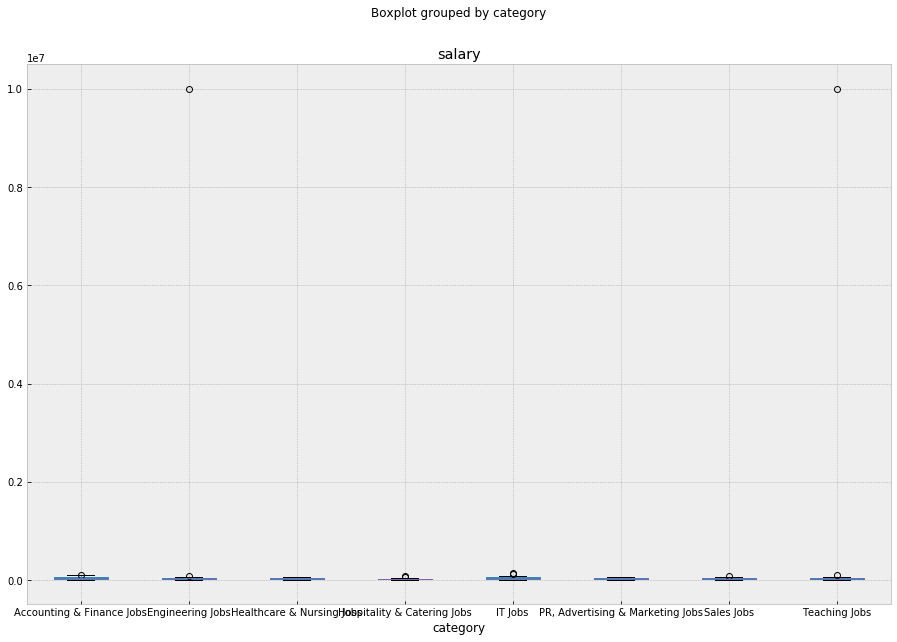

In [101]:
dfy = dft[['category', 'salary_corrected']].copy()
dfy = pd.DataFrame(dfy)
dfy.columns = ['category', 'salary']
dfy = dfy[dfy.salary != 'NAN']     # Remove null values
dfy = dfy[dfy.salary != '0']       # Remove zero values
#dfy = dfy[dfy.salary != '10000000']       # Remove zero values
dfy['salary'] = dfy.salary.astype(float)

sal = dfy.salary.astype(float)
dfy.boxplot(column='salary', by='category', figsize=(15,10))

In [102]:
# The presence of a 10,000,00 salary figure in teaching has squashed teh bloxplot and needs to be removed.
# The box plot is re-drawn

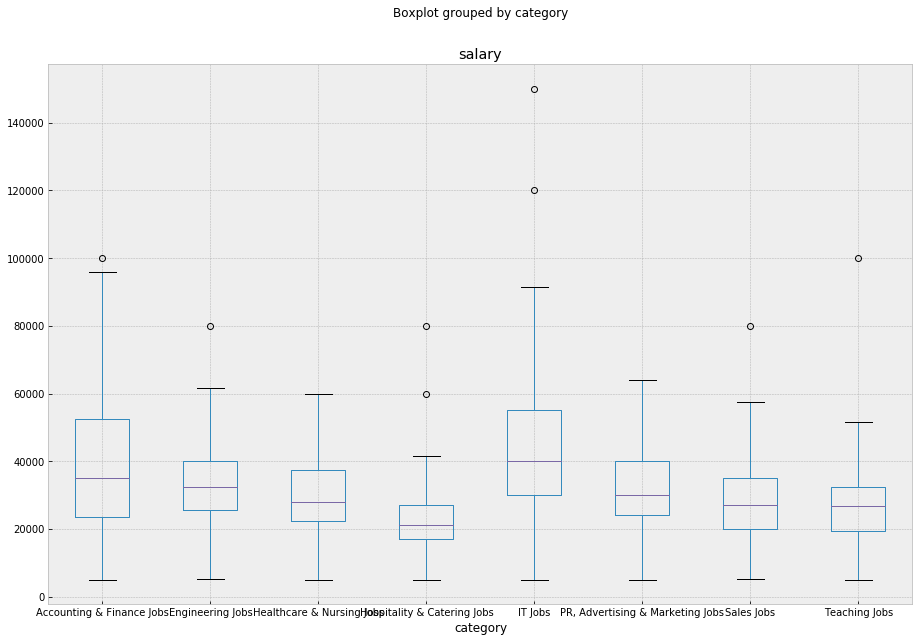

In [103]:
dft['salary_corrected'] = dft.salary_corrected.apply(lambda x: repMe(x, '10000000', 'NAN'))
dfy = dft[['category', 'salary_corrected']].copy()
dfy = pd.DataFrame(dfy)
dfy.columns = ['category', 'salary']
dfy = dfy[dfy.salary != 'NAN']     # Remove null values
dfy = dfy[dfy.salary != '0']       # Remove zero values

dfy['salary'] = dfy.salary.astype(float)

sal = dfy.salary.astype(float)
dfy.boxplot(column='salary', by='category', figsize=(15,10))

In [104]:
cats = dfy.category.unique()

df_min = dfy.groupby(['category']).min()
df_min.columns = ['min']
df_max = dfy.groupby(['category']).max()
df_max.columns = ['max']

for cat in cats:
    qq = getLowerUpper(dfy, cat) 
    
    lo = getLowerOutliers(dfy, cat, qq[1])
    print('For', cat, '\n', 'lower quartile=', qq[1])
    print('Lower outliers:\n', getLowerOutliers(dfy, cat, qq[1]),'\n')    
    
    uq = getUpperOutliers(dfy, cat, qq[2])
    print('upper quartile=', qq[2])
    print('Upper outliers:\n', getUpperOutliers(dfy, cat, qq[2]),'\n')
    print('--------------------------------------')



For Engineering Jobs 
 lower quartile= 3750.0
Lower outliers:
 Empty DataFrame
Columns: [category, salary]
Index: [] 

upper quartile= 61750.0
Upper outliers:
                category   salary
48361  Engineering Jobs  80000.0 

--------------------------------------
For Accounting & Finance Jobs 
 lower quartile= -20000.0
Lower outliers:
 Empty DataFrame
Columns: [category, salary]
Index: [] 

upper quartile= 96000.0
Upper outliers:
                         category    salary
50585  Accounting & Finance Jobs  100000.0 

--------------------------------------
For Healthcare & Nursing Jobs 
 lower quartile= 0.0
Lower outliers:
 Empty DataFrame
Columns: [category, salary]
Index: [] 

upper quartile= 60000.0
Upper outliers:
 Empty DataFrame
Columns: [category, salary]
Index: [] 

--------------------------------------
For Hospitality & Catering Jobs 
 lower quartile= 2000.0
Lower outliers:
 Empty DataFrame
Columns: [category, salary]
Index: [] 

upper quartile= 42000.0
Upper outliers:
    

###### Boxplot and the calculations to get the lower and upper bounds for quariles, 
######  There was a 10,000,000 salary which made the scale of the boxplot
######  unreadable. That was removed.
######  Based on the above which is in line with the boxplot:
######  we can observe the following finding: 
 - Engineering: There is a 80K salary which could be correct, given the upper quartile being 61750
 - Accounting &Finance: There is a 100K salary which could be correct, given the upper quartile being 96K
 - Hospitality & Catering: 80K and 60K salary could still be correct with respect to 42K upper quartile
 - IT jobs: 120K and 150K with respect to 92500 are not ruled out either. Their job titles are IOS developer and sharepoint solution analyst which may be hard to find
 - Sales Jobs: 80K compared with 57500 could be right for a 'Medical Sales Representative Cardiothoracic'.
 - Teaching jobs: 100K is well above the $51750 is interesting but the position being a 'New Business Development Exec/Manager' could justify that.
    
Therefore, the only vaue we can confiently say is not right is the 10,000,000.

In [105]:
print('Number of entries with salary > 10M is', len(dft[dft.salary_corrected == '10000000']))
print('Number of entries with salary = 0 is', len(dft[dft.salary_corrected == '0']))

Number of entries with salary > 10M is 0
Number of entries with salary = 0 is 0


In [106]:
# Calculate the average salary in each job category
dfg = dfy.groupby(['category']).mean().round(0)
dfg.columns = ['avg_salary']
dfg['avg_salary'] = dfg['avg_salary'].astype(int)
dfg

,avg_salary
category,
Accounting & Finance Jobs,40042
Engineering Jobs,33541
Healthcare & Nursing Jobs,30139
Hospitality & Catering Jobs,22343
IT Jobs,43587
"PR, Advertising & Marketing Jobs",32276
Sales Jobs,28285
Teaching Jobs,26335


In [107]:
### Replace null values in salary with average of salaies in every category
dft['new_sal'] = dft.apply(repna, axis=1)

In [108]:
#Ensure the Salary column is clean from any null or the similar
len(dft[dft.new_sal.isnull()])
len(dft[dft.new_sal == '0'])
len(dft[dft.new_sal == ''])
len(dft[dft.new_sal == 'NaN'])
len(dft[dft.new_sal == 'NAN'])
len(dft[dft.new_sal == 'nan'])
len(dft[dft.new_sal == np.nan])

0

0

0

0

0

0

0

In [109]:
# Drop old column and retype the new Salary column
dft = dft.drop(['salary_corrected'], axis=1)
dft['new_sal'] = dft.new_sal.astype(float)

###### Validation Summary
- Check for nulls and the likes such as dashes and empty strings
- Normalise by removing text as part of the salary
- Convert per hour to annual
- Replace salary range by average.
- Identify outlier values
- Calculate average salary for each category
- Replace null values with averges

In [110]:
# Reseuqence and rename columns
dft = dft[['id', 'title', 'location', 'company', 'contract_type', 'contract_time', 'category', 'new_sal', 'open_date', 'close_date', 'source']]
dft.columns = ['Id', 'Title', 'Location', 'Company', 'ContractType', 'ContractTime', 'Category', 'Salary', 'OpenDate', 'CloseDate', 'SourceName']

In [111]:
# Any opf the columns except for the web site is considered as part of the uniqueness.

In [112]:
cols = ['Title', 'Location', 'Company', 'ContractType', 'ContractTime', 'Category', 'Salary', 'OpenDate', 'CloseDate'] 
duplicates = dft[dft.duplicated(cols,keep=False)]
print( "There are "+ str(len(duplicates)) + " duplicate records found")
duplicates.sort_values(by=duplicates.columns.tolist()).head(10)

There are 6 duplicate records found


,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
8023,67290277,QUALITY ASSURANCE ENVIRONMENTAL MANAGER NOTTIN...,NOTTINGHAM,STEPHEN JAMES CONSULTING,non-specified,permanent,Healthcare & Nursing Jobs,35000.0,20120110T150000,20120409T150000,tntjobs.co.uk
47471,71808610,PENSIONS ADMINISTRATORS TEMPORARY/CONTRACT,UK,ABENEFIT2U,non-specified,contract,Accounting & Finance Jobs,24000.0,20130801T150000,20130831T150000,professionalpensionsjobs.com
54482,72653751,BARCLAYS FUTURE LEADERS DEVELOPMENT PROGRAMMES,HACKNEY,BARCLAYS,non-specified,non-specified,IT Jobs,36000.0,20121223T150000,20130221T150000,grb.uk.com
55165,72705205,PENSIONS ADMINISTRATORS TEMPORARY/CONTRACT,UK,ABENEFIT2U,non-specified,contract,Accounting & Finance Jobs,24000.0,20130801T150000,20130831T150000,cv-library.co.uk
55167,72705240,BARCLAYS FUTURE LEADERS DEVELOPMENT PROGRAMMES,HACKNEY,BARCLAYS,non-specified,non-specified,IT Jobs,36000.0,20121223T150000,20130221T150000,grb.uk.com
55168,72705244,QUALITY ASSURANCE ENVIRONMENTAL MANAGER NOTTIN...,NOTTINGHAM,STEPHEN JAMES CONSULTING,non-specified,permanent,Healthcare & Nursing Jobs,35000.0,20120110T150000,20120409T150000,tntjobs.co.uk


In [113]:
dft = dft.drop_duplicates(cols, keep='last')
# Making sure duplicates are droped.
duplicates = dft[dft.duplicated(cols,keep=False)]
print( "There are "+ str(len(duplicates)) + " duplicate records found")

There are 0 duplicate records found


In [114]:
dft.dtypes

Id                int64
Title            object
Location         object
Company          object
ContractType     object
ContractTime     object
Category         object
Salary          float64
OpenDate         object
CloseDate        object
SourceName       object
dtype: object

In [115]:
dft.to_csv('dataset1_solution.csv', index =False)